In [1]:
import numpy as np

x = np.load("/project/msoleyma_1026/ecp/data/pair_embeddings/text/train-emotion/conv_18_utterance_pair_9_2.npy")
print(x.shape)

(1, 1536)


In [77]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [78]:
import sklearn; print(sklearn.__version__)

1.2.2


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import json
from torch.utils.data import DataLoader, Dataset
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import os
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [79]:
with open('/project/msoleyma_1026/ecp/data/utterance_pairs_emotion_flags_train.json', 'r') as f:
    data = json.load(f)

In [80]:
class_one_count = 0
class_zero_count = 0
for conv in data:
    for key, value in conv.items():
        for utterance_pair in value:
            if utterance_pair['valid_pair'] == 1:
                class_one_count += 1
            elif utterance_pair['valid_pair'] == 0:
                class_zero_count += 1
                
print(class_zero_count)
print(class_one_count)
# class_counts = torch.tensor([class_zero_count, class_one_count])
# weight = 1.0 / class_counts.float()
# class_weights = weight / weight.sum()
pos_weight = torch.tensor(class_zero_count).float() / torch.tensor(class_one_count).float()
pos_weight, pos_weight.shape


37081
7621


(tensor(4.8656), torch.Size([]))

In [81]:
pos_weight

tensor(4.8656)

In [115]:
def debug_collate_fn(batch):
    batch_tensors = []
    convIDs = []
    utterancePairs = []
    for item in batch:
        tensor_data = item[:2]
        batch_tensors.append(tensor_data)
        convIDs.append(item[2])
        utterancePairs.append(item[3])

    try:
        tensor_batch = torch.utils.data.dataloader.default_collate(batch_tensors)
    except RuntimeError as e:
        print("Error during tensor collation. Printing tensor sizes:")
        for idx, (inputs, labels) in enumerate(batch_tensors):
            print(f"Item {idx} - Inputs shape: {inputs.shape}, Labels shape: {labels.shape}")
        raise e

    return (*tensor_batch, convIDs, utterancePairs)

class PairDataset(Dataset):
    def __init__(self, data_file, embeddings_dir, mode='train'):
        self.data_file = data_file
        self.embeddings_dir = embeddings_dir
        self.mode = mode
        self.pairs = self.load_pairs()
        self.emotion_list = sorted(['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness','surprise'])
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(self.emotion_list)
        self.one_hot_encoder = OneHotEncoder(sparse=False)
        self.one_hot_encoder.fit(np.array(self.emotion_list).reshape(-1, 1))
        if self.mode == 'eval':
            self.predicted_emotions = self.load_predicted_emotions()

    def __len__(self):
        return len(self.pairs)

    def load_pairs(self):
        with open(self.data_file, 'r') as file:
            pairs = json.load(file)
        return pairs

    def load_predicted_emotions(self):
        with open('/project/msoleyma_1026/ecp/data/predictions/late_fusion_predictions_text.json', 'r') as file:
            predictions = json.load(file)
        prediction_dict = {}
        for conversation in predictions:
            conversation_id = conversation['conversation_id']
            for utterance in conversation['utterances']:
                utterance_id = utterance['utt_id']
                emotion = utterance['emotion']
                if conversation_id not in prediction_dict:
                    prediction_dict[conversation_id] = {}
                prediction_dict[conversation_id][utterance_id] = emotion
        return prediction_dict

    def load_embeddings(self, conv_id, utterance_pair_ids):
        primary_dir = self.embeddings_dir

        file_name = f"conv_{conv_id}_utterance_pair_{utterance_pair_ids[0]}_{utterance_pair_ids[1]}.npy"
        primary_embedding_file = os.path.join(primary_dir, file_name)

        if os.path.exists(primary_embedding_file):
          embedding = np.load(primary_embedding_file)
        else:
          raise FileNotFoundError(f"Embedding file not found for {file_name}")
        return torch.from_numpy(embedding).float()

    def __getitem__(self, idx):
      try:
        conv_pairs = self.pairs[idx]
        context_embeddings = []
        pair_labels = []
        utterancePairList = []
        emotions = []

        first_conversation_id = next(iter(conv_pairs))
        for utterance_pair in conv_pairs[first_conversation_id]:
            utterance_pair_ids = utterance_pair['utterance_pair']
            utterancePairList.append(utterance_pair_ids)
            if self.mode == 'train':
                emotions.append(utterance_pair['emotion'])
            elif self.mode == 'eval':
                emotions.append(self.predicted_emotions[int(first_conversation_id)][int(utterance_pair_ids[0])])
        if self.mode == 'eval':
            emotions = self.label_encoder.inverse_transform(emotions).tolist()

        encoded_emotions = self.one_hot_encoder.transform(np.array(emotions).reshape(-1, 1))

        encoded_emotions_tensor = torch.tensor(encoded_emotions, dtype=torch.float32)

        context_embeddings = [self.load_embeddings(first_conversation_id, utt['utterance_pair']).float() for utt in conv_pairs[first_conversation_id]]
        
        for i in range(len(context_embeddings)):
            reshaped_encoded_emotions = encoded_emotions_tensor[i].view(1, -1)
            concatenated_embedding = torch.cat((context_embeddings[i], reshaped_encoded_emotions), dim=1)
            context_embeddings[i] = concatenated_embedding
        pair_labels = [utt['valid_pair'] for utt in conv_pairs[first_conversation_id]]

        if self.mode == 'train':
            max_seq_length = 253
        elif self.mode == 'eval':
            max_seq_length = 561
        num_to_add = 0
        padded_embeddings = []
        if len(context_embeddings) < max_seq_length:
            num_to_add = max_seq_length - len(context_embeddings)
            zero_tensor = torch.zeros((1,1543), dtype=torch.float32)
            context_embeddings += [zero_tensor] * num_to_add
        context_embeddings_padded = torch.cat(context_embeddings, dim=0)
        pair_labels += [-1] * num_to_add
        pair_labels_tensor = torch.tensor(pair_labels, dtype=torch.float32)

        return context_embeddings_padded, pair_labels_tensor, first_conversation_id, utterancePairList
      except Exception as e:
        print(f"Error loading item {idx}: {e}")
        raise e

      return self.embeddings[idx], torch.tensor(int(len(self.data[idx]['emotion-cause_pairs']) > 0), dtype=torch.float32)

class PairDetector(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_emotions, n_layers=2, dropout=0.2):
        super(PairDetector, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_emotions = num_emotions
        self.n_layers = n_layers

        encoder_layers = TransformerEncoderLayer(d_model=input_dim, nhead=1, dim_feedforward=hidden_dim, dropout=dropout, batch_first=True)
        self.transformer_encoder = TransformerEncoder(encoder_layers, num_layers=n_layers)

        self.decoder_emotion = nn.Linear(input_dim, num_emotions)

    def forward(self, context_embeddings):
        encoded_context = self.transformer_encoder(context_embeddings)
        prediction_emotion = self.decoder_emotion(encoded_context)  # (batch_size, seq_length, num_emotions)
        return prediction_emotion.squeeze()

In [128]:
input_size = 1543
hidden_size = 1024
num_classes = 1
lr = 1e-5
batch_size = 64
num_epochs = 20
num_layers = 4
print_interval = 5

if torch.cuda.is_available():
    torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pairs_labels_file = '/project/msoleyma_1026/ecp/data/utterance_pairs_emotion_flags_train.json'
embeddings_dir = '/project/msoleyma_1026/ecp/data/pair_embeddings/text/train'

train_dataset = PairDataset(pairs_labels_file, embeddings_dir, mode='train')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=debug_collate_fn)

model = PairDetector(input_size, hidden_size, num_classes, n_layers=num_layers).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
# criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)  
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(4.).float()) 

total_loss = 0.0
total_batches = 0

for epoch in range(num_epochs):
    model.train()
    epoch_loss_emotion = 0.0
    num_batches = 0
    for batch_idx, (inputs, labels, convID, utterancePairs) in enumerate(train_loader):
        inputs = inputs.float()
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.squeeze()

        active_outputs = outputs[labels != -1]
        active_pairs = labels[labels != -1]
        loss = criterion(active_outputs, active_pairs)
        loss.backward()
        optimizer.step()

        epoch_loss_emotion += loss.item()
        total_loss += loss.item()
        total_batches += 1
        # print(loss.item())

        if (batch_idx + 1) % print_interval == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(train_loader)}], '
                  f'Loss: {loss.item():.4f}')

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss_emotion / len(train_loader):.4f}")

overall_avg_loss = total_loss / total_batches
print(f"Overall Average Training Loss: {overall_avg_loss:.4f}")

torch.save(model.state_dict(), '/project/msoleyma_1026/ecp/models/pair_detection_model_late_text.pt')

/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/20], Batch [5/17], Loss: 1.1193
Epoch [1/20], Batch [10/17], Loss: 1.0119
Epoch [1/20], Batch [15/17], Loss: 1.0380
Epoch 1/20, Loss: 1.0554
Epoch [2/20], Batch [5/17], Loss: 0.9935
Epoch [2/20], Batch [10/17], Loss: 0.9822
Epoch [2/20], Batch [15/17], Loss: 1.0357
Epoch 2/20, Loss: 1.0111
Epoch [3/20], Batch [5/17], Loss: 1.0104
Epoch [3/20], Batch [10/17], Loss: 1.0537
Epoch [3/20], Batch [15/17], Loss: 1.0325
Epoch 3/20, Loss: 0.9835
Epoch [4/20], Batch [5/17], Loss: 0.9712
Epoch [4/20], Batch [10/17], Loss: 0.9296
Epoch [4/20], Batch [15/17], Loss: 0.9396
Epoch 4/20, Loss: 0.9700
Epoch [5/20], Batch [5/17], Loss: 0.9437
Epoch [5/20], Batch [10/17], Loss: 0.9547
Epoch [5/20], Batch [15/17], Loss: 0.9324
Epoch 5/20, Loss: 0.9563
Epoch [6/20], Batch [5/17], Loss: 0.9381
Epoch [6/20], Batch [10/17], Loss: 0.9173
Epoch [6/20], Batch [15/17], Loss: 0.9189
Epoch 6/20, Loss: 0.9399
Epoch [7/20], Batch [5/17], Loss: 0.9532
Epoch [7/20], Batch [10/17], Loss: 0.9363
Epoch [7/20], Bat

In [129]:
def evaluate_model_for_roc(model, dataloader, device):
    model.eval()
    all_scores = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            context_embeddings, target_pairs, _, _ = batch  # Adjust based on your actual data structure
            
            context_embeddings = context_embeddings.to(device)
            target_pairs = target_pairs.to(device)
            
            output = model(context_embeddings)

            target_pairs = target_pairs.squeeze()

            active_outputs = output[target_pairs != -1]
            active_pairs = target_pairs[target_pairs != -1]
            sigmoid_output = torch.sigmoid(active_outputs)            

            # Initialize valid_scores and valid_labels as empty tensors
            valid_scores = torch.tensor([], device=device)
            valid_labels = torch.tensor([], device=device)

            # Ensure the shapes are correct for indexing
            valid_scores = sigmoid_output
            valid_labels = active_pairs
            
            all_scores.extend(valid_scores.cpu().tolist())
            all_labels.extend(valid_labels.cpu().tolist())

    return all_scores, all_labels


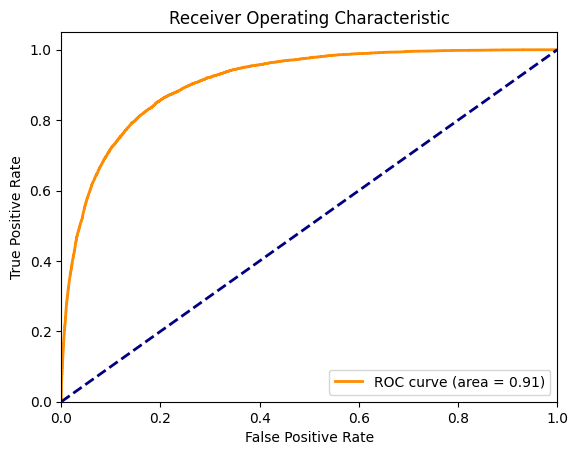

In [130]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming you have collected all_scores and all_labels from your dataset
pairs_labels_file_roc = '/project/msoleyma_1026/ecp/data/utterance_pairs_emotion_flags_train.json'
embeddings_dir_roc = '/project/msoleyma_1026/ecp/data/pair_embeddings/text/train'
train_dataset_roc = PairDataset(pairs_labels_file_roc, embeddings_dir_roc, mode='train')
train_loader_roc = DataLoader(train_dataset_roc, batch_size=batch_size, shuffle=True, collate_fn=debug_collate_fn)
scores, labels = evaluate_model_for_roc(model, train_loader_roc, device)

fpr, tpr, thresholds = roc_curve(labels, scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [131]:
# Calculate the optimal threshold: the one with the highest tpr - fpr
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print('Optimal threshold:', optimal_threshold)

Optimal threshold: 0.288230299949646


In [132]:
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    TP = 0
    FP = 0
    FN = 0
    TN = 0

    with torch.no_grad():
        for batch in dataloader:
            context_embeddings, target_pairs, conversation_ids, utterance_ids = batch
            
            context_embeddings = context_embeddings.to(device)
            target_pairs = target_pairs.to(device)

            output = model(context_embeddings)

            target_pairs = target_pairs.squeeze()

            active_outputs = output[target_pairs != -1]
            active_pairs = target_pairs[target_pairs != -1]
            loss = criterion(active_outputs, active_pairs)

            total_loss += loss.item()
            sigmoid_output = torch.sigmoid(active_outputs)

            threshold = optimal_threshold #calculated using ROC
            # threshold = 0.5
            binary_predictions = (sigmoid_output >= threshold).float()

            correct_predictions = (binary_predictions == active_pairs)
            # correct_predictions = correct_predictions[target_pairs != -1]
            
            total_correct += correct_predictions.sum().item()
            total_samples += active_pairs.size(0)

            # Calculate TP, FP, FN
            TP += ((binary_predictions == 1) & (active_pairs == 1)).sum().item()
            FP += ((binary_predictions == 1) & (active_pairs == 0)).sum().item()
            FN += ((binary_predictions == 0) & (active_pairs == 1)).sum().item()
            TN += ((binary_predictions == 0) & (active_pairs == 0)).sum().item()

            # Store conversation and utterance IDs along with predicted emotions
            # for i in range(len(conversation_ids)):
            #     conv_id = conversation_ids[i]
            #     utter_id = utterance_ids[i]
            #     prediction = binary_predictions[i].tolist()
            #     predictions[(conv_id, utter_id)] = tuple(prediction)

    print(f"True Positives: {TP}")
    print(f"False Positives: {FP}")
    print(f"False Negatives: {FN}")
    print(f"True Negatives: {TN}")
    print(f"Total samples: {total_samples}")

    average_loss = total_loss / len(dataloader)
    accuracy = total_correct / total_samples

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return average_loss, accuracy, precision, recall, f1_score

In [133]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pairs_labels_file = '/project/msoleyma_1026/ecp/data/utterance_pairs_emotion_flags_test.json'
embeddings_dir = '/project/msoleyma_1026/ecp/data/pair_embeddings/text/test'

test_dataset = PairDataset(pairs_labels_file, embeddings_dir, mode='eval')

test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=debug_collate_fn)

val_loss, val_accuracy, val_precision, val_recall, val_f1_score = evaluate_model(model, test_dataloader, criterion)
print(f'Test Loss: {val_loss:.4f}, Test Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1_score:.4f}')

True Positives: 1348
False Positives: 2470
False Negatives: 445
True Negatives: 6069
Total samples: 10332
Validation Loss: 0.9420, Test Accuracy: 0.7179, Precision: 0.3531, Recall: 0.7518, F1 Score: 0.4805


For pos_w: 4.7


/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/20], Batch [5/17], Loss: 1.1018
Epoch [1/20], Batch [10/17], Loss: 1.0744
Epoch [1/20], Batch [15/17], Loss: 1.1270
Epoch 1/20, Loss: 1.1282
Epoch [2/20], Batch [5/17], Loss: 1.0940
Epoch [2/20], Batch [10/17], Loss: 1.0999
Epoch [2/20], Batch [15/17], Loss: 1.0684
Epoch 2/20, Loss: 1.0626
Epoch [3/20], Batch [5/17], Loss: 1.0131
Epoch [3/20], Batch [10/17], Loss: 1.0387
Epoch [3/20], Batch [15/17], Loss: 1.0089
Epoch 3/20, Loss: 1.0338
Epoch [4/20], Batch [5/17], Loss: 1.0477
Epoch [4/20], Batch [10/17], Loss: 1.0756
Epoch [4/20], Batch [15/17], Loss: 1.0249
Epoch 4/20, Loss: 1.0198
Epoch [5/20], Batch [5/17], Loss: 1.0101
Epoch [5/20], Batch [10/17], Loss: 1.0528
Epoch [5/20], Batch [15/17], Loss: 0.9444
Epoch 5/20, Loss: 1.0066
Epoch [6/20], Batch [5/17], Loss: 0.9492
Epoch [6/20], Batch [10/17], Loss: 1.0047
Epoch [6/20], Batch [15/17], Loss: 0.9083
Epoch 6/20, Loss: 0.9874
Epoch [7/20], Batch [5/17], Loss: 0.9687
Epoch [7/20], Batch [10/17], Loss: 0.9316
Epoch [7/20], Bat

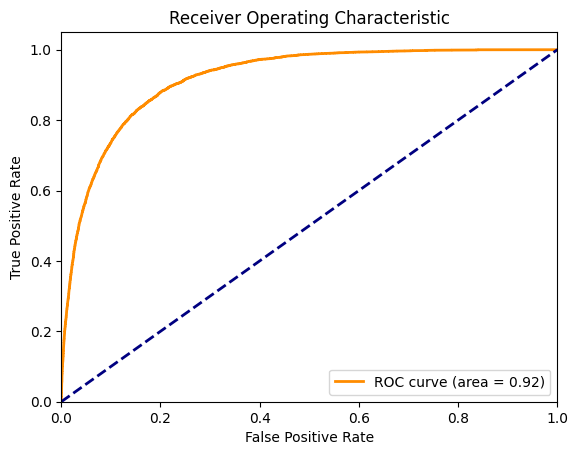

Optimal threshold: 0.4167535901069641
True Positives: 1380
False Positives: 2740
False Negatives: 413
True Negatives: 5799
Total samples: 10332
For pos_weight: 4.7 ---> Validation Loss: 1.0691, Test Accuracy: 0.6948, Precision: 0.3350, Recall: 0.7697, F1 Score: 0.4668
For pos_w: 4.6


/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/20], Batch [5/17], Loss: 1.1641
Epoch [1/20], Batch [10/17], Loss: 1.1275
Epoch [1/20], Batch [15/17], Loss: 1.0623
Epoch 1/20, Loss: 1.1237
Epoch [2/20], Batch [5/17], Loss: 1.1261
Epoch [2/20], Batch [10/17], Loss: 1.0488
Epoch [2/20], Batch [15/17], Loss: 1.0555
Epoch 2/20, Loss: 1.0660
Epoch [3/20], Batch [5/17], Loss: 1.0372
Epoch [3/20], Batch [10/17], Loss: 0.9957
Epoch [3/20], Batch [15/17], Loss: 1.0217
Epoch 3/20, Loss: 1.0435
Epoch [4/20], Batch [5/17], Loss: 0.9343
Epoch [4/20], Batch [10/17], Loss: 1.0297
Epoch [4/20], Batch [15/17], Loss: 1.0136
Epoch 4/20, Loss: 1.0213
Epoch [5/20], Batch [5/17], Loss: 1.0004
Epoch [5/20], Batch [10/17], Loss: 0.9361
Epoch [5/20], Batch [15/17], Loss: 1.0235
Epoch 5/20, Loss: 1.0034
Epoch [6/20], Batch [5/17], Loss: 0.9967
Epoch [6/20], Batch [10/17], Loss: 0.9606
Epoch [6/20], Batch [15/17], Loss: 1.0006
Epoch 6/20, Loss: 0.9869
Epoch [7/20], Batch [5/17], Loss: 0.9958
Epoch [7/20], Batch [10/17], Loss: 0.9672
Epoch [7/20], Bat

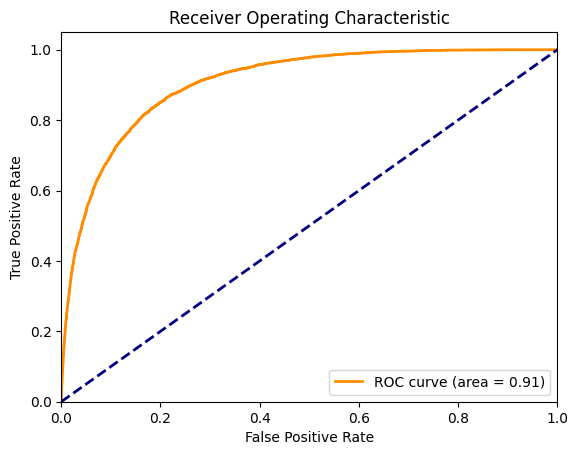

Optimal threshold: 0.4198710024356842
True Positives: 1376
False Positives: 2856
False Negatives: 417
True Negatives: 5683
Total samples: 10332
For pos_weight: 4.6 ---> Validation Loss: 1.0216, Test Accuracy: 0.6832, Precision: 0.3251, Recall: 0.7674, F1 Score: 0.4568
For pos_w: 4.5


/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/20], Batch [5/17], Loss: 1.0773
Epoch [1/20], Batch [10/17], Loss: 1.0587
Epoch [1/20], Batch [15/17], Loss: 1.0144
Epoch 1/20, Loss: 1.0938
Epoch [2/20], Batch [5/17], Loss: 1.0759
Epoch [2/20], Batch [10/17], Loss: 1.0200
Epoch [2/20], Batch [15/17], Loss: 1.0105
Epoch 2/20, Loss: 1.0430
Epoch [3/20], Batch [5/17], Loss: 1.0423
Epoch [3/20], Batch [10/17], Loss: 1.0250
Epoch [3/20], Batch [15/17], Loss: 1.0454
Epoch 3/20, Loss: 1.0171
Epoch [4/20], Batch [5/17], Loss: 1.0698
Epoch [4/20], Batch [10/17], Loss: 1.0218
Epoch [4/20], Batch [15/17], Loss: 1.0207
Epoch 4/20, Loss: 0.9995
Epoch [5/20], Batch [5/17], Loss: 1.0313
Epoch [5/20], Batch [10/17], Loss: 0.9968
Epoch [5/20], Batch [15/17], Loss: 1.0287
Epoch 5/20, Loss: 0.9825
Epoch [6/20], Batch [5/17], Loss: 0.9544
Epoch [6/20], Batch [10/17], Loss: 0.8897
Epoch [6/20], Batch [15/17], Loss: 0.9867
Epoch 6/20, Loss: 0.9682
Epoch [7/20], Batch [5/17], Loss: 0.9787
Epoch [7/20], Batch [10/17], Loss: 0.9021
Epoch [7/20], Bat

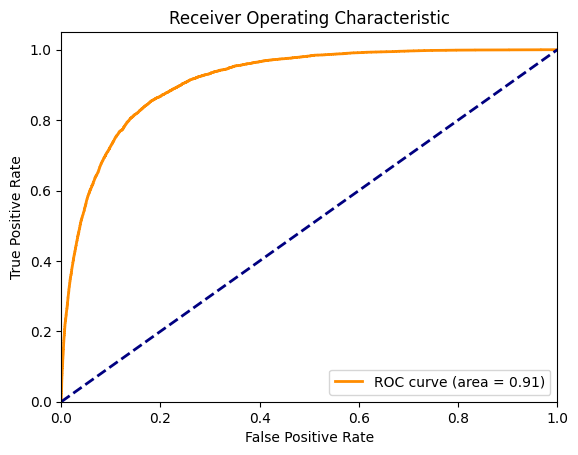

Optimal threshold: 0.4653850197792053
True Positives: 1347
False Positives: 2640
False Negatives: 446
True Negatives: 5899
Total samples: 10332
For pos_weight: 4.5 ---> Validation Loss: 1.0033, Test Accuracy: 0.7013, Precision: 0.3378, Recall: 0.7513, F1 Score: 0.4661
For pos_w: 4.4


/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/20], Batch [5/17], Loss: 1.0785
Epoch [1/20], Batch [10/17], Loss: 1.0586
Epoch [1/20], Batch [15/17], Loss: 1.0600
Epoch 1/20, Loss: 1.0832
Epoch [2/20], Batch [5/17], Loss: 1.0245
Epoch [2/20], Batch [10/17], Loss: 1.0306
Epoch [2/20], Batch [15/17], Loss: 1.0149
Epoch 2/20, Loss: 1.0316
Epoch [3/20], Batch [5/17], Loss: 0.9601
Epoch [3/20], Batch [10/17], Loss: 1.0090
Epoch [3/20], Batch [15/17], Loss: 0.9982
Epoch 3/20, Loss: 1.0036
Epoch [4/20], Batch [5/17], Loss: 0.9920
Epoch [4/20], Batch [10/17], Loss: 0.9316
Epoch [4/20], Batch [15/17], Loss: 1.0108
Epoch 4/20, Loss: 0.9863
Epoch [5/20], Batch [5/17], Loss: 1.0357
Epoch [5/20], Batch [10/17], Loss: 0.9277
Epoch [5/20], Batch [15/17], Loss: 0.9604
Epoch 5/20, Loss: 0.9670
Epoch [6/20], Batch [5/17], Loss: 1.0217
Epoch [6/20], Batch [10/17], Loss: 0.9198
Epoch [6/20], Batch [15/17], Loss: 0.9838
Epoch 6/20, Loss: 0.9463
Epoch [7/20], Batch [5/17], Loss: 0.9326
Epoch [7/20], Batch [10/17], Loss: 0.9117
Epoch [7/20], Bat

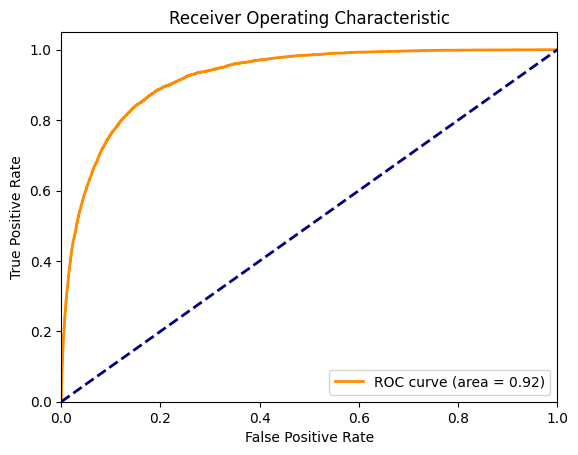

Optimal threshold: 0.48715317249298096
True Positives: 1408
False Positives: 2741
False Negatives: 385
True Negatives: 5798
Total samples: 10332
For pos_weight: 4.4 ---> Validation Loss: 0.9633, Test Accuracy: 0.6974, Precision: 0.3394, Recall: 0.7853, F1 Score: 0.4739
For pos_w: 4.3


/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/20], Batch [5/17], Loss: 1.1081
Epoch [1/20], Batch [10/17], Loss: 1.0729
Epoch [1/20], Batch [15/17], Loss: 1.0273
Epoch 1/20, Loss: 1.0749
Epoch [2/20], Batch [5/17], Loss: 1.0435
Epoch [2/20], Batch [10/17], Loss: 1.0083
Epoch [2/20], Batch [15/17], Loss: 0.9754
Epoch 2/20, Loss: 1.0247
Epoch [3/20], Batch [5/17], Loss: 1.0737
Epoch [3/20], Batch [10/17], Loss: 1.0161
Epoch [3/20], Batch [15/17], Loss: 0.9570
Epoch 3/20, Loss: 0.9993
Epoch [4/20], Batch [5/17], Loss: 0.9583
Epoch [4/20], Batch [10/17], Loss: 0.9467
Epoch [4/20], Batch [15/17], Loss: 1.0250
Epoch 4/20, Loss: 0.9784
Epoch [5/20], Batch [5/17], Loss: 0.9533
Epoch [5/20], Batch [10/17], Loss: 0.9765
Epoch [5/20], Batch [15/17], Loss: 0.9785
Epoch 5/20, Loss: 0.9671
Epoch [6/20], Batch [5/17], Loss: 0.9831
Epoch [6/20], Batch [10/17], Loss: 0.9629
Epoch [6/20], Batch [15/17], Loss: 0.9000
Epoch 6/20, Loss: 0.9512
Epoch [7/20], Batch [5/17], Loss: 0.8960
Epoch [7/20], Batch [10/17], Loss: 0.9416
Epoch [7/20], Bat

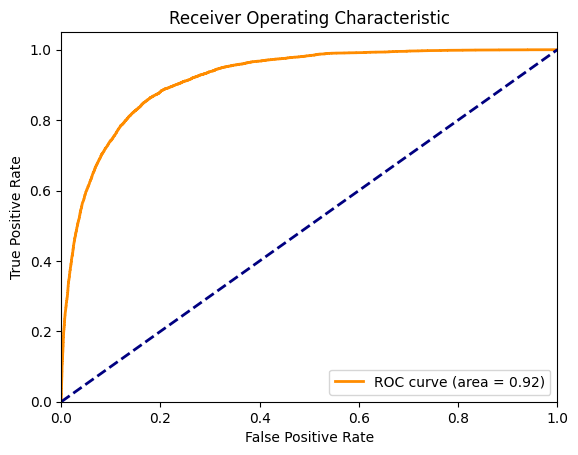

Optimal threshold: 0.4111604392528534
True Positives: 1379
False Positives: 2614
False Negatives: 414
True Negatives: 5925
Total samples: 10332
For pos_weight: 4.3 ---> Validation Loss: 0.9508, Test Accuracy: 0.7069, Precision: 0.3454, Recall: 0.7691, F1 Score: 0.4767
For pos_w: 4.1


/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/20], Batch [5/17], Loss: 1.0115
Epoch [1/20], Batch [10/17], Loss: 1.0263
Epoch [1/20], Batch [15/17], Loss: 1.0696
Epoch 1/20, Loss: 1.0458
Epoch [2/20], Batch [5/17], Loss: 0.9982
Epoch [2/20], Batch [10/17], Loss: 0.9876
Epoch [2/20], Batch [15/17], Loss: 0.9893
Epoch 2/20, Loss: 0.9991
Epoch [3/20], Batch [5/17], Loss: 1.0327
Epoch [3/20], Batch [10/17], Loss: 0.9798
Epoch [3/20], Batch [15/17], Loss: 0.9583
Epoch 3/20, Loss: 0.9729
Epoch [4/20], Batch [5/17], Loss: 0.9563
Epoch [4/20], Batch [10/17], Loss: 0.9786
Epoch [4/20], Batch [15/17], Loss: 0.9192
Epoch 4/20, Loss: 0.9525
Epoch [5/20], Batch [5/17], Loss: 0.9369
Epoch [5/20], Batch [10/17], Loss: 0.9590
Epoch [5/20], Batch [15/17], Loss: 0.9181
Epoch 5/20, Loss: 0.9411
Epoch [6/20], Batch [5/17], Loss: 0.9211
Epoch [6/20], Batch [10/17], Loss: 0.8793
Epoch [6/20], Batch [15/17], Loss: 0.9620
Epoch 6/20, Loss: 0.9194
Epoch [7/20], Batch [5/17], Loss: 0.8870
Epoch [7/20], Batch [10/17], Loss: 0.9229
Epoch [7/20], Bat

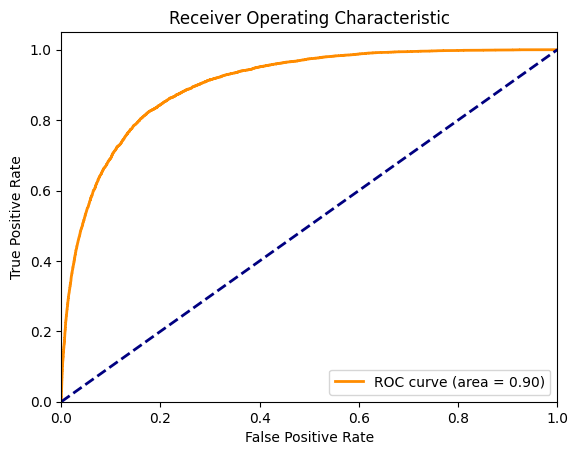

Optimal threshold: 0.32060763239860535
True Positives: 1256
False Positives: 2307
False Negatives: 537
True Negatives: 6232
Total samples: 10332
For pos_weight: 4.1 ---> Validation Loss: 1.0396, Test Accuracy: 0.7247, Precision: 0.3525, Recall: 0.7005, F1 Score: 0.4690


In [134]:
pos_ws = [4.7, 4.6, 4.5, 4.4, 4.3, 4.1]
for pos_w in pos_ws:   
    print(f"For pos_w: {pos_w}") 
    input_size = 1543
    hidden_size = 1024
    num_classes = 1
    lr = 1e-5
    batch_size = 64
    num_epochs = 20
    num_layers = 4
    print_interval = 5

    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    pairs_labels_file = '/project/msoleyma_1026/ecp/data/utterance_pairs_emotion_flags_train.json'
    embeddings_dir = '/project/msoleyma_1026/ecp/data/pair_embeddings/text/train'

    train_dataset = PairDataset(pairs_labels_file, embeddings_dir, mode='train')

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=debug_collate_fn)

    model = PairDetector(input_size, hidden_size, num_classes, n_layers=num_layers).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)  
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_w).float()) 

    total_loss = 0.0
    total_batches = 0

    for epoch in range(num_epochs):
        model.train()
        epoch_loss_emotion = 0.0
        num_batches = 0
        for batch_idx, (inputs, labels, convID, utterancePairs) in enumerate(train_loader):
            inputs = inputs.float()
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            labels = labels.squeeze()

            active_outputs = outputs[labels != -1]
            active_pairs = labels[labels != -1]
            loss = criterion(active_outputs, active_pairs)
            loss.backward()
            optimizer.step()

            epoch_loss_emotion += loss.item()
            total_loss += loss.item()
            total_batches += 1
            # print(loss.item())

            if (batch_idx + 1) % print_interval == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(train_loader)}], '
                    f'Loss: {loss.item():.4f}')

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss_emotion / len(train_loader):.4f}")

    overall_avg_loss = total_loss / total_batches
    print(f"Overall Average Training Loss: {overall_avg_loss:.4f}")

    torch.save(model.state_dict(), '/project/msoleyma_1026/ecp/models/pair_detection_model_late_text.pt')

    scores, labels = evaluate_model_for_roc(model, train_loader_roc, device)

    fpr, tpr, thresholds = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Calculate the optimal threshold: the one with the highest tpr - fpr
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print('Optimal threshold:', optimal_threshold)

    def evaluate_model(model, dataloader, criterion):
        model.eval()
        total_loss = 0.0
        total_correct = 0
        total_samples = 0

        TP = 0
        FP = 0
        FN = 0
        TN = 0

        with torch.no_grad():
            for batch in dataloader:
                context_embeddings, target_pairs, conversation_ids, utterance_ids = batch
                
                context_embeddings = context_embeddings.to(device)
                target_pairs = target_pairs.to(device)

                output = model(context_embeddings)

                target_pairs = target_pairs.squeeze()

                active_outputs = output[target_pairs != -1]
                active_pairs = target_pairs[target_pairs != -1]
                loss = criterion(active_outputs, active_pairs)

                total_loss += loss.item()
                sigmoid_output = torch.sigmoid(active_outputs)

                threshold = optimal_threshold #calculated using ROC
                # threshold = 0.5
                binary_predictions = (sigmoid_output >= threshold).float()

                correct_predictions = (binary_predictions == active_pairs)
                # correct_predictions = correct_predictions[target_pairs != -1]
                
                total_correct += correct_predictions.sum().item()
                total_samples += active_pairs.size(0)

                # Calculate TP, FP, FN
                TP += ((binary_predictions == 1) & (active_pairs == 1)).sum().item()
                FP += ((binary_predictions == 1) & (active_pairs == 0)).sum().item()
                FN += ((binary_predictions == 0) & (active_pairs == 1)).sum().item()
                TN += ((binary_predictions == 0) & (active_pairs == 0)).sum().item()

                # Store conversation and utterance IDs along with predicted emotions
                # for i in range(len(conversation_ids)):
                #     conv_id = conversation_ids[i]
                #     utter_id = utterance_ids[i]
                #     prediction = binary_predictions[i].tolist()
                #     predictions[(conv_id, utter_id)] = tuple(prediction)

        print(f"True Positives: {TP}")
        print(f"False Positives: {FP}")
        print(f"False Negatives: {FN}")
        print(f"True Negatives: {TN}")
        print(f"Total samples: {total_samples}")

        average_loss = total_loss / len(dataloader)
        accuracy = total_correct / total_samples

        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        return average_loss, accuracy, precision, recall, f1_score

    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    pairs_labels_file = '/project/msoleyma_1026/ecp/data/utterance_pairs_emotion_flags_test.json'
    embeddings_dir = '/project/msoleyma_1026/ecp/data/pair_embeddings/text/test'

    test_dataset = PairDataset(pairs_labels_file, embeddings_dir, mode='eval')

    test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=debug_collate_fn)

    val_loss, val_accuracy, val_precision, val_recall, val_f1_score = evaluate_model(model, test_dataloader, criterion)
    print(f'For pos_weight: {pos_w} ---> Validation Loss: {val_loss:.4f}, Test Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1_score:.4f}')

In [43]:
def evaluate_model(model, dataloader, criterion, predicted_emotions_dict):
    model.eval()
    total_loss = 0.0
    total_pair_correct = 0
    total_emotion_correct = 0
    total_combined_correct = 0
    total_samples = 0

    with torch.no_grad():
        for batch in dataloader:
            context_embeddings, target_pairs, conversation_ids, utterance_ids = batch
            context_embeddings = context_embeddings.to(device)
            target_pairs = target_pairs.to(device)

            output = model(context_embeddings)
            target_pairs = target_pairs.squeeze()

            active_outputs = output[target_pairs != -1]
            active_pairs = target_pairs[target_pairs != -1]
            loss = criterion(active_outputs, active_pairs)

            total_loss += loss.item()
            sigmoid_output = torch.sigmoid(active_outputs)
            threshold = 0.5
            binary_predictions = (sigmoid_output >= threshold).float()

            correct_pair_predictions = (binary_predictions == active_pairs)
            total_pair_correct += correct_pair_predictions.sum().item()
            
            # Calculate emotion accuracy
            for i, (conv_id, utter_pair) in enumerate(zip(conversation_ids, utterance_ids)):
                true_emotion = predicted_emotions_dict.get(conv_id, {}).get(utter_pair[0], -1)
                predicted_emotion = predicted_emotions_dict.get(conv_id, {}).get(utter_pair[1], -1)
                if true_emotion == predicted_emotion:
                    total_emotion_correct += 1
                    if correct_pair_predictions[i].item():
                        total_combined_correct += 1

            total_samples += active_pairs.size(0)

    average_loss = total_loss / len(dataloader)
    pair_accuracy = total_pair_correct / total_samples
    emotion_accuracy = total_emotion_correct / total_samples
    combined_accuracy = total_combined_correct / total_samples

    return average_loss, pair_accuracy, emotion_accuracy, combined_accuracy

In [44]:
import json
import torch
from torch.utils.data import DataLoader

# ... include your imports, definitions, and any other necessary code here ...

def load_predicted_emotions(json_filepath):
    with open(json_filepath, 'r') as file:
        data = json.load(file)
    predicted_emotions_dict = {}
    for conversation in data:
        conversation_id = str(conversation['conversation_id'])
        for utterance in conversation['utterances']:
            utterance_id = str(utterance['utt_id'])
            emotion = utterance['emotion']
            if conversation_id not in predicted_emotions_dict:
                predicted_emotions_dict[conversation_id] = {}
            predicted_emotions_dict[conversation_id][utterance_id] = emotion
    return predicted_emotions_dict


# Presuming you have a test dataset and a model already defined, as well as a criterion for loss calculation

if torch.cuda.is_available():
    torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming you have a class PairDataset
pairs_labels_file = '/project/msoleyma_1026/ecp/data/utterance_pairs_emotion_flags_test.json'
embeddings_dir = '/project/msoleyma_1026/ecp/data/pair_embeddings/text/test'

test_dataset = PairDataset(pairs_labels_file, embeddings_dir, mode='eval')
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=debug_collate_fn)

# Load predicted emotions
predicted_emotions_dict = load_predicted_emotions('/project/msoleyma_1026/ecp/data/predictions/late_fusion_predictions_text.json')

# Evaluate the model
val_loss, pair_accuracy, emotion_accuracy, combined_accuracy = evaluate_model(
    model, test_dataloader, criterion, predicted_emotions_dict
)

print(f'Validation Loss: {val_loss:.4f}, Pair Accuracy: {pair_accuracy:.4f}, '
      f'Emotion Accuracy: {emotion_accuracy:.4f}, Combined Accuracy: {combined_accuracy:.4f}')

/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


TypeError: unhashable type: 'list'

In [52]:
normalized_weights

tensor([0.1705, 0.8295])

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import json
from torch.utils.data import DataLoader, Dataset
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import os
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [8]:
def debug_collate_fn(batch):
    batch_tensors = []
    convIDs = []
    utterancePairs = []
    for item in batch:
        tensor_data = item[:2]
        batch_tensors.append(tensor_data)
        convIDs.append(item[2])
        utterancePairs.append(item[3])

    try:
        tensor_batch = torch.utils.data.dataloader.default_collate(batch_tensors)
    except RuntimeError as e:
        print("Error during tensor collation. Printing tensor sizes:")
        for idx, (inputs, labels) in enumerate(batch_tensors):
            print(f"Item {idx} - Inputs shape: {inputs.shape}, Labels shape: {labels.shape}")
        raise e

    return (*tensor_batch, convIDs, utterancePairs)

In [14]:
class PairDataset(Dataset):
    def __init__(self, data_file, embeddings_dir, mode='train'):
        self.data_file = data_file
        self.embeddings_dir = embeddings_dir
        self.mode = mode
        self.pairs = self.load_pairs()
        self.emotion_list = sorted(['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness','surprise'])
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(self.emotion_list)
        self.one_hot_encoder = OneHotEncoder(sparse=False)
        self.one_hot_encoder.fit(np.array(self.emotion_list).reshape(-1, 1))
        if self.mode == 'eval':
            self.predicted_emotions = self.load_predicted_emotions()

    def __len__(self):
        print(sum(len(conv_pairs) for conv_dict in self.pairs for conv_pairs in conv_dict.values()))
        return sum(len(conv_pairs) for conv_dict in self.pairs for conv_pairs in conv_dict.values())

    def load_pairs(self):
        with open(self.data_file, 'r') as file:
            pairs = json.load(file)
        return pairs

    def load_predicted_emotions(self):
        with open('/project/msoleyma_1026/ecp/data/predictions/late_fusion_predictions_text.json', 'r') as file:
            predictions = json.load(file)
        prediction_dict = {}
        for conversation in predictions:
            conversation_id = conversation['conversation_id']
            for utterance in conversation['utterances']:
                utterance_id = utterance['utt_id']
                emotion = utterance['emotion']
                if conversation_id not in prediction_dict:
                    prediction_dict[conversation_id] = {}
                prediction_dict[conversation_id][utterance_id] = emotion
        return prediction_dict

    def load_embeddings(self, conv_id, utterance_pair_ids):
        primary_dir = self.embeddings_dir

        file_name = f"conv_{conv_id}_utterance_pair_{utterance_pair_ids[0]}_{utterance_pair_ids[1]}.npy"
        primary_embedding_file = os.path.join(primary_dir, file_name)

        if os.path.exists(primary_embedding_file):
          embedding = np.load(primary_embedding_file)
        else:
          raise FileNotFoundError(f"Embedding file not found for {file_name}")
        return torch.from_numpy(embedding).float()

    def __getitem__(self, idx):
        cumulative_indices = [len(conv_pairs) for conv_dict in self.pairs for conv_pairs in conv_dict.values()]
        cumulative_indices = np.cumsum(cumulative_indices)

        conv_idx = np.searchsorted(cumulative_indices, idx, side='right')
        if conv_idx == 0:
            conv_id = list(self.pairs[0].keys())[0]
        else:
            conv_id = list(self.pairs[conv_idx].keys())[0]

        print(self.pairs[conv_idx])
        conv_pairs = self.pairs[conv_idx][str(conv_id)]
        utterance_pair = conv_pairs[idx - (cumulative_indices[conv_idx - 1] if conv_idx > 0 else 0)]
        utterance_pair_ids = utterance_pair['utterance_pair']
        emotion = utterance_pair['emotion'] if self.mode == 'train' else self.predicted_emotions[int(conv_id)][int(utterance_pair_ids[0])]
        encoded_emotion = self.label_encoder.transform([emotion])
        encoded_emotion_tensor = torch.tensor(self.one_hot_encoder.transform(encoded_emotion.reshape(-1, 1)), dtype=torch.float32)
        context_embedding = self.load_embeddings(conv_id, utterance_pair_ids)
        pair_label = utterance_pair['valid_pair']

        context_embedding_with_emotion = torch.cat((context_embedding, encoded_emotion_tensor), dim=1)

        return context_embedding_with_emotion, pair_label



In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import json
from torch.utils.data import DataLoader, Dataset
import os
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

class PairDetectorMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(PairDetectorMLP, self).__init__()
        self.mlp = MLP(input_dim, hidden_dim, num_classes)

    def forward(self, context_embeddings):
        return self.mlp(context_embeddings)

input_size = 1543
hidden_size = 1024
num_classes = 1
lr = 1e-3
batch_size = 64
num_epochs = 1
print_interval = 5

if torch.cuda.is_available():
    torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pairs_labels_file = '/project/msoleyma_1026/ecp/data/utterance_pairs_emotion_flags_train.json'
embeddings_dir = '/project/msoleyma_1026/ecp/data/pair_embeddings/text/train'

train_dataset = PairDataset(pairs_labels_file, embeddings_dir, mode='train')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=debug_collate_fn)

model = PairDetectorMLP(input_size, hidden_size, num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss()

for epoch in range(num_epochs):
    model.train()
    epoch_loss_emotion = 0.0
    for batch_idx, (inputs, labels, convID, utterancePairs) in enumerate(train_loader):
        inputs = inputs.float()
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.squeeze()

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss_emotion += loss.item()
        print(loss.item())

        if (batch_idx + 1) % print_interval == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(train_loader)}], '
                  f'Loss: {loss.item():.4f}')

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss_emotion / len(train_loader):.4f}")

torch.save(model.state_dict(), '/project/msoleyma_1026/ecp/models/pair_detection_model_late_text.pt')

def evaluate_model(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for batch in dataloader:
            context_embeddings, target_pairs, conversation_ids, utterance_ids = batch

            context_embeddings = context_embeddings.to(device)
            target_pairs = target_pairs.to(device)

            output = model(context_embeddings)

            loss = criterion(output, target_pairs)

            total_loss += loss.item()
            total_samples += target_pairs.size(0)

    average_loss = total_loss / len(dataloader)

    return average_loss

if torch.cuda.is_available():
    torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pairs_labels_file = '/project/msoleyma_1026/ecp/data/utterance_pairs_emotion_flags_test.json'
embeddings_dir = '/project/msoleyma_1026/ecp/data/pair_embeddings/text/test'

test_dataset = PairDataset(pairs_labels_file, embeddings_dir, mode='eval')

test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=debug_collate_fn)

val_loss = evaluate_model(model, test_dataloader, criterion)
print(f'Validation Loss: {val_loss:.4f}')

/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


44702
44702
44702
44702
{'55': [{'utterance_pair': [4, 1], 'emotion': 'surprise', 'valid_pair': 0}, {'utterance_pair': [4, 2], 'emotion': 'surprise', 'valid_pair': 0}, {'utterance_pair': [4, 3], 'emotion': 'surprise', 'valid_pair': 1}, {'utterance_pair': [4, 4], 'emotion': 'surprise', 'valid_pair': 0}, {'utterance_pair': [7, 1], 'emotion': 'joy', 'valid_pair': 0}, {'utterance_pair': [7, 2], 'emotion': 'joy', 'valid_pair': 0}, {'utterance_pair': [7, 3], 'emotion': 'joy', 'valid_pair': 1}, {'utterance_pair': [7, 4], 'emotion': 'joy', 'valid_pair': 0}, {'utterance_pair': [7, 5], 'emotion': 'joy', 'valid_pair': 0}, {'utterance_pair': [7, 6], 'emotion': 'joy', 'valid_pair': 0}, {'utterance_pair': [7, 7], 'emotion': 'joy', 'valid_pair': 1}, {'utterance_pair': [8, 1], 'emotion': 'surprise', 'valid_pair': 0}, {'utterance_pair': [8, 2], 'emotion': 'surprise', 'valid_pair': 0}, {'utterance_pair': [8, 3], 'emotion': 'surprise', 'valid_pair': 0}, {'utterance_pair': [8, 4], 'emotion': 'surprise', '

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''